## Attempt for solving navier-stoke equation using PINNS

let us take the following PDE
$$
\frac{\partial u}{\partial t}
+ u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}
=
-\frac{1}{\rho} \frac{\partial p}{\partial x}
+ \nu \left(
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
\right)
$$
\
$$
\frac{\partial v}{\partial t}
+ u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}
=
-\frac{1}{\rho} \frac{\partial p}{\partial y}
+ \nu \left(
\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}
\right)
\\[10pt]
$$
\
$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$
Or alternatively, we can use
\
$$
\left( \frac{\partial u}{\partial x} \right)^2 +
2 \left( \frac{\partial u}{\partial y} \right)
\left( \frac{\partial v}{\partial x} \right) +
\left( \frac{\partial v}{\partial y} \right)^2
= -\frac{1}{\rho}
\left(
\frac{\partial^2 p}{\partial x^2}
+ \frac{\partial^2 p}{\partial y^2}
\right)
$$

\
The boundary conditions for the velocity are the following.
$$
u(t, x, l_y) = 1, \quad u(t, x, 0) = 0, \quad
u(t, 0, y) = 0, \quad u(t, l_x, y) = 0
$$
\
$$
v(t, x, l_y) = 0, \quad v(t, x, 0) = 0, \quad
v(t, 0, y) = 0, \quad v(t, l_x, y) = 0
$$

consider $l_x = l_y = 1$

The boundary condition for the pressure
$$
\frac{\partial p}{\partial x}\Big|_{x=0} = 0, \quad
\frac{\partial p}{\partial x}\Big|_{x=l_x} = 0, \quad
\frac{\partial p}{\partial y}\Big|_{y=0} = 0, \quad
p(t, x, l_y) = 0
$$

### PINNs attempt

We are going to train a neural network on the boundary conditions and the pde as constraints to find $u, v \& p$

The neural networkd is going to take 3 inputs (time, x, y) and produces 3 output (u, v, p), thus we need to initialize the inputs with the right dimensions

We are going to have $t \in [0,0.1]$ since we only want to see how system evolves in a small time step

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
x_0, x_f = 0.0, 1.0
y_0, y_f = 0.0, 1.0
t_0, t_f = 0.0 , 1.0

In [4]:
# set the device to be a GPU, if it is there
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##Functions to plot the outputs (pressure, velocities)

In [13]:
def plot_pressure_velocity(x, y, u, v, p):
  X, Y = np.meshgrid(x, y)
  figure, axs = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
  output = [p, u, v]
  title = ["Pressure", "Velocity u", "Velocity v"]
  for i in range(len(axs)):
    ax = axs[i]
    ax.set_title(title[i])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colormap = ax.pcolormesh(X, Y, output[i], cmap="jet", shading="auto")
    figure.colorbar(colormap, ax=ax)
  plt.show()

def plot_stream_lines(x, y, u, v, p):
  X, Y = np.meshgrid(x, y)
  figure = plt.figure(figsize=(5, 4), tight_layout=True, dpi=120)
  ax = figure.add_subplot(111)
  ax.set_xlim(x[0], x[-1])
  ax.set_ylim(y[0], y[-1])
  ax.set_title("Velocity vector lines & Pressure")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  colormap = ax.pcolormesh(X, Y, p, cmap="jet", shading="auto")
  figure.colorbar(colormap)
  plt.streamplot(X, Y, u, v, color="black")
  plt.show()

In [6]:
def plot_final_t_step(pinn, t=t_f, vector_lines=True):
  #create test input data
  x_test = torch.linspace(x_0, x_f, 50).to(device)
  y_test = torch.linspace(y_0, y_f , 50).to(device)
  test_data = torch.cartesian_prod(x_test, y_test, torch.tensor([t]).to(device))
  x_input_test, y_input_test, t_input_test = torch.split(test_data, 1, 1)

  #create a mesh
  x_test, y_test = x_test.cpu(), y_test.cpu()
  # x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="xy")

  #get the output of the PINN
  u_test, v_test, p_test = pinn(x_input_test, y_input_test, t_input_test)
  u_test = u_test.squeeze().reshape(x_grid.shape).cpu().numpy()
  v_test = v_test.squeeze().reshape(x_grid.shape).cpu().numpy()
  p_test = p_test.squeeze().reshape(x_grid.shape).cpu().numpy()

  #plot the output
  if vector_lines:
    plot_stream_lines(x_test, y_test, u_test, v_test, p_test)

  else:
    plot_pressure_velocity(x_test, y_test, u_test.T, v_test.T, p_test.T)

In [7]:
#You need to copy the file to the current google colab environment
#if you do not use colab and your file in the same director
#then you can imoprt directly
path1 = "/content/gdrive/MyDrive/MX-Project/PINN_demo/cavity_flow_FD.py"
path2 = "/content/gdrive/MyDrive/MX-Project/PINN_demo/helpers_FD.py"
!cp {path1} /content
!cp {path2} /content
import cavity_flow_FD as FD

##Finite Difference Approximation

We will start by looking at the results obtained from the code for the finite difference simualtion first. (For the full details and the code look at the repository files related to the finite difference method).

In [10]:
FD_simulator = FD.FD_CAV()
FD_simulator.set_resolution(x_num_points=50, y_num_points=50)
FD_simulator.set_time_step(0.001)
u_fd, v_fd, p_fd = FD_simulator.simulate(t_final=1)
x_fd = FD_simulator.get_x_points()
y_fd = FD_simulator.get_y_points()

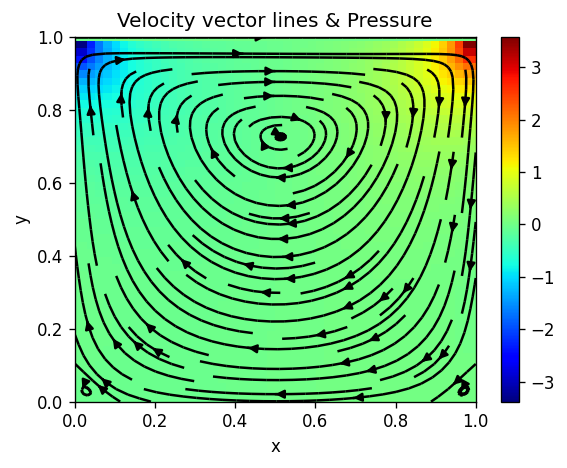

In [11]:
plot_stream_lines(x_fd, y_fd, u_fd, v_fd, p_fd)

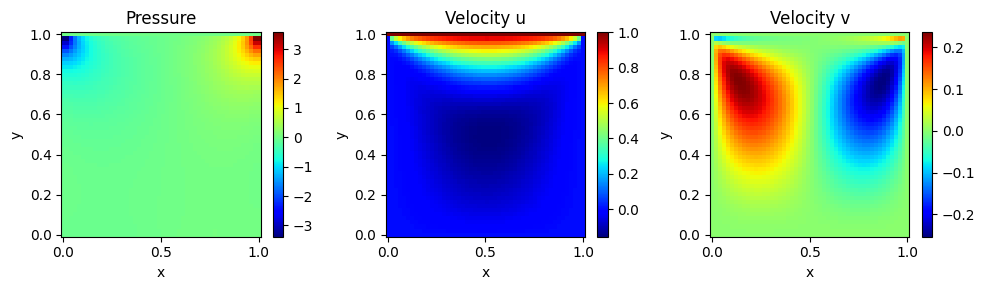

In [14]:
plot_pressure_velocity(x_fd, y_fd, u_fd, v_fd, p_fd)

##PINN

The code for the PINN starts from here

In [15]:
def generate_data(x_num = 10, y_num=10, t_num=10):
    x_axis = torch.linspace(x_0, x_f,  x_num + 2)[1:-1] #exclude the boundary
    y_axis = torch.linspace(y_0, y_f, y_num + 2)[1: -1]
    t_axis = torch.linspace(t_0, t_f, t_num )
    data = torch.cartesian_prod(x_axis, y_axis, t_axis)
    return torch.split(data, 1, 1)

In [16]:
# the model
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN).to(device),
            activation()

        ])


        self.fch =nn.Sequential(*[ nn.Sequential(*[
            nn.Linear(N_HIDDEN, N_HIDDEN).to(device),
            activation()

        ]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN,N_OUTPUT).to(device)
        def weights_initialization(self):
                """"
                When we define all the modules such as the layers in '__init__()'
                method above, these are all stored in 'self.modules()'.
                We go through each module one by one. This is the entire network,
                basically.
                """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight,gain=1.0)
                nn.init.constant_(m.bias, 0)
    def forward(self, x, y, t):
        inputs = torch.cat((x, y, t), dim=1)
        inputs = self.fcs(inputs)
        inputs = self.fch(inputs)
        output = self.fce(inputs)

        # Split the output into u, v, and p
        u, v, p = torch.split(output, 1, dim=1)
        return u, v, p

In [17]:
x_physics , y_physics, t_physics = generate_data(10, 10, 10)
x_physics = x_physics.requires_grad_().to(device)
y_physics = y_physics.requires_grad_().to(device)
t_physics = t_physics.requires_grad_().to(device)
examples_num = len(x_physics)

#Boundary
y_up = torch.tensor( [y_f]*examples_num ).unsqueeze(-1).to(device)
y_down = torch.tensor( [y_0]*examples_num ).unsqueeze(-1).requires_grad_().to(device)
x_right = torch.tensor( [x_f]*examples_num ).unsqueeze(-1).requires_grad_().to(device)
x_left = torch.tensor( [x_0]*examples_num ).unsqueeze(-1).requires_grad_().to(device)

#Initial values
x_interior = torch.linspace(x_0, x_f, 12)[1:-1]
y_interior = torch.linspace(y_0, y_f, 12)[1:-1]
initial_points = torch.cartesian_prod(x_interior, y_interior, torch.tensor([t_0]))
x_interior, y_interior, t_initial = torch.split(initial_points.to(device), 1, 1)

#Simulation Data
FD_data = FD.FD_CAV()
FD_data.set_resolution(10, 10)
x_train = FD_data.get_x_points()
y_train = FD_data.get_y_points()
t_train = np.array([0.5])
u_train, v_train, p_train = FD_data.simulate(0.5)
x_train = torch.tensor(x_train).type(torch.float32)
y_train = torch.tensor(y_train).type(torch.float32)
t_train = torch.tensor(t_train).type(torch.float32)
data = torch.cartesian_prod(x_train, y_train, t_train).to(device)
x_train, y_train, t_train = torch.split(data, 1, 1)
u_train = torch.tensor(u_train).reshape(x_train.size()).type(torch.float32).to(device)
v_train = torch.tensor(v_train).reshape(x_train.size()).type(torch.float32).to(device)
p_train = torch.tensor(p_train).reshape(x_train.size()).type(torch.float32).to(device)

In [18]:
def pde_loss(x, y, t, net, density=1.0, viscosity=0.1):
    u, v, p = net(x,y,t)
    u_x = torch.autograd.grad(u, x,torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x),create_graph=True)[0]
    u_y = torch.autograd.grad(u, y,torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y,torch.ones_like(u_y), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]

    v_x = torch.autograd.grad(v, x,torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x),create_graph=True)[0]
    v_y = torch.autograd.grad(v, y,torch.ones_like(v), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y,torch.ones_like(v_y), create_graph=True)[0]
    v_t = torch.autograd.grad(v,t,torch.ones_like(v), create_graph=True)[0]

    p_x = torch.autograd.grad(p,x,torch.ones_like(p), create_graph=True)[0]
    # p_xx = torch.autograd.grad(p_x,x,torch.ones_like(p_x), create_graph=True)[0]
    p_y = torch.autograd.grad(p,y,torch.ones_like(p), create_graph=True)[0]
    # p_yy = torch.autograd.grad(p_y,y,torch.ones_like(p_y), create_graph=True)[0]

    # Compute PDE losses
    loss1 = u_t + u * u_x + v * u_y + (1/density) * p_x - viscosity * (u_xx + u_yy)
    loss2 = v_t + u * v_x + v * v_y + (1/density) * p_y - viscosity * (v_xx + v_yy)
    # loss3 = (u_x)**2 + 2 * u_y * v_x + (v_y)**2 + (1/density) * (p_xx + p_yy)
    loss3 = u_x + v_y   #This one gives better result

    # Store losses in a dictionary
    losses = {
        'PDE1': loss1,
        'PDE2': loss2,
        'PDE3': loss3
    }
    loss_added = torch.mean(loss1**2) + torch.mean(loss2**2) + torch.mean(loss3**2)


    return losses, loss_added


### setting the boundary conditions
We are going to set the boundary conditions for neuman and dirchlit as the following

### building the NN

We are going to build NN with 3 inputs and 3 outpus as we mentioned before

In [33]:
pinn = FCN(3,3,32,5)
mse_cost_function = torch.nn.MSELoss()
optimizer = optim.Adam(pinn.parameters(), lr=1e-6)

top: 0.02034195512533188, right: 0.021483028307557106, down:0.0004088944406248629, left: 0.007145961280912161
initial loss: 0.010103929787874222 pde:0.015326793305575848


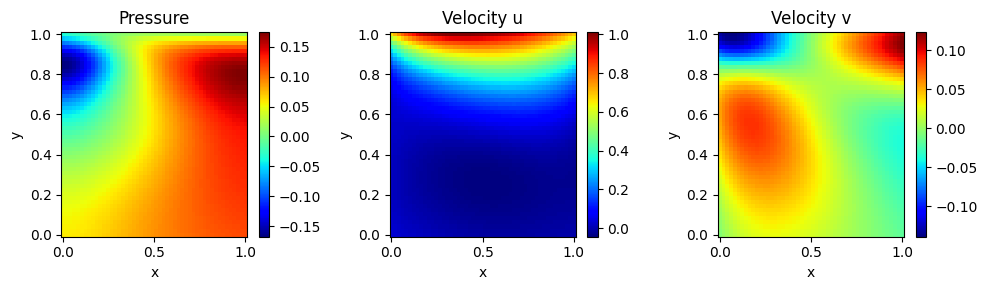

top: 0.020295321941375732, right: 0.021444302052259445, down:0.00040873768739402294, left: 0.007112440187484026
initial loss: 0.010083395056426525 pde:0.015321241691708565


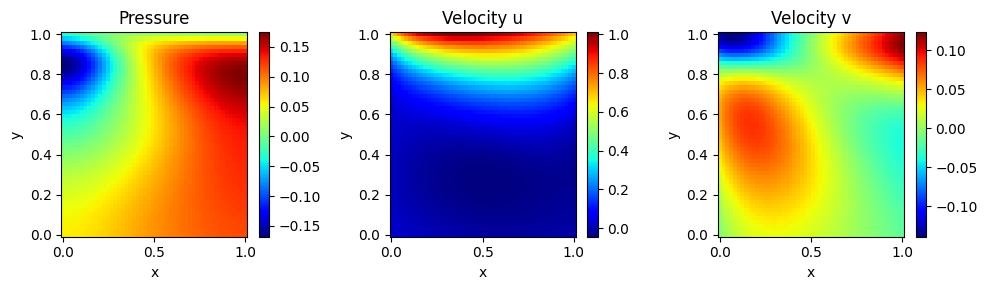

top: 0.02024829015135765, right: 0.021405166015028954, down:0.00040860663284547627, left: 0.00707880686968565
initial loss: 0.010062930174171925 pde:0.015315961092710495


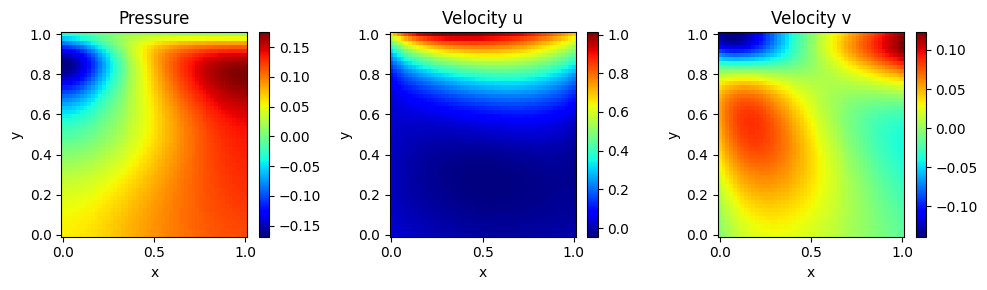

top: 0.020200686529278755, right: 0.021365920081734657, down:0.00040846806950867176, left: 0.0070451488718390465
initial loss: 0.010042333044111729 pde:0.01531087514013052


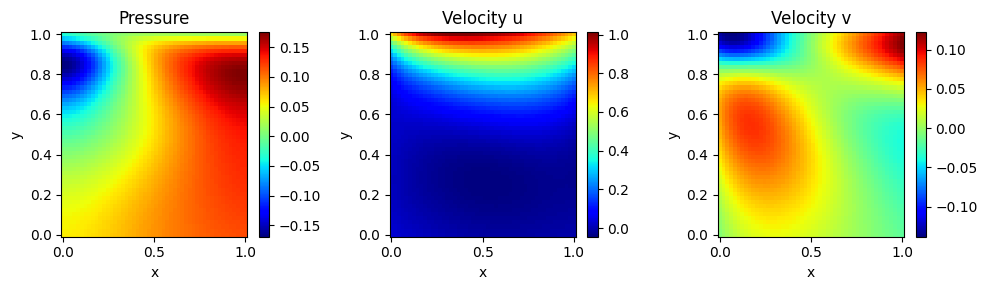

top: 0.02015303634107113, right: 0.021326478570699692, down:0.0004083187668584287, left: 0.007011535577476025
initial loss: 0.010021454654633999 pde:0.01530575379729271


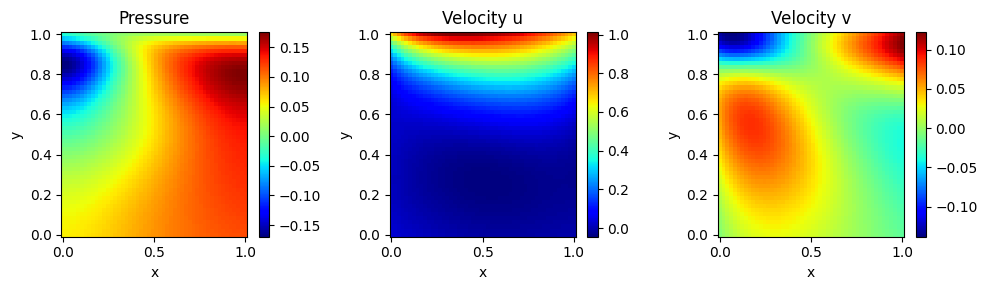

top: 0.020105529576539993, right: 0.021287083625793457, down:0.00040816274122335017, left: 0.006977894343435764
initial loss: 0.01000020932406187 pde:0.015300196595489979


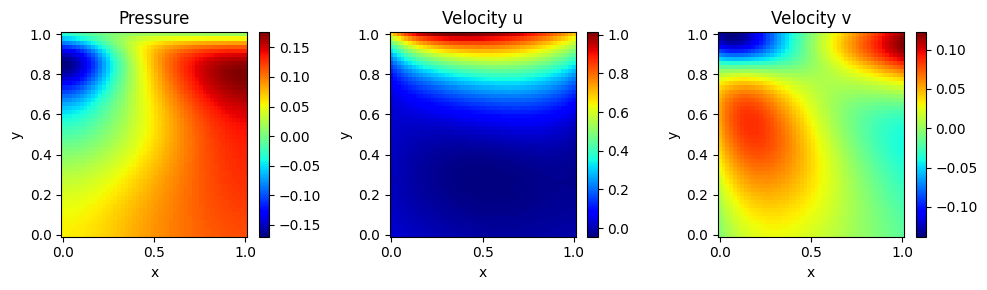

top: 0.020057689398527145, right: 0.021247481927275658, down:0.00040797845576889813, left: 0.006944186985492706
initial loss: 0.009978932328522205 pde:0.015294698998332024


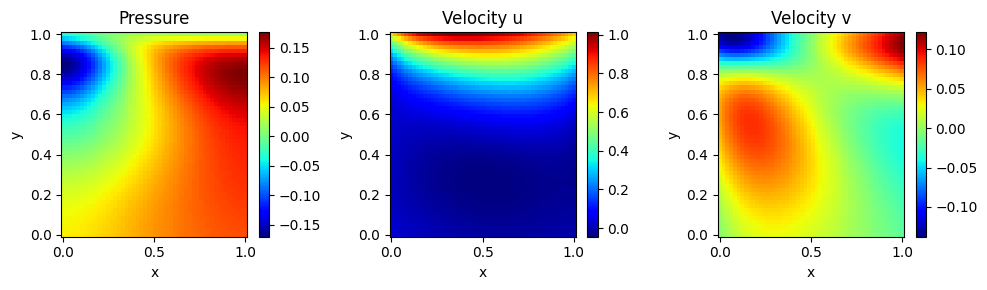

top: 0.020009739324450493, right: 0.021207621321082115, down:0.0004077676567249, left: 0.0069102756679058075
initial loss: 0.009957652539014816 pde:0.01528911292552948


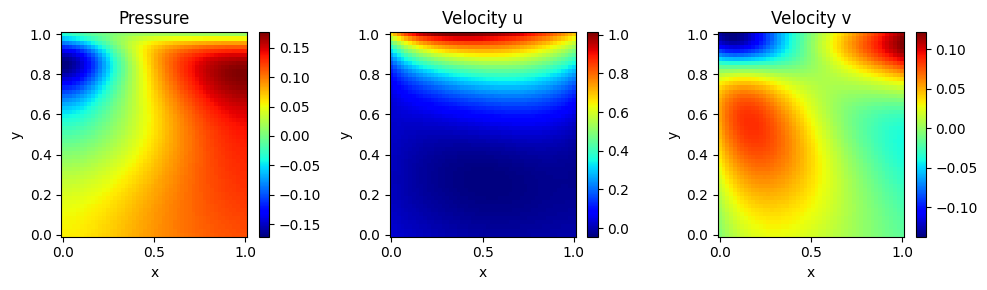

top: 0.019961774349212646, right: 0.021167833358049393, down:0.00040752149652689695, left: 0.0068762232549488544
initial loss: 0.009936260059475899 pde:0.015283092856407166


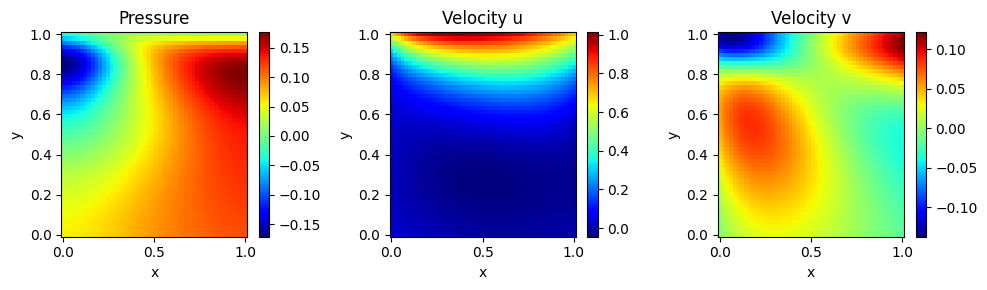

top: 0.019913874566555023, right: 0.021127652376890182, down:0.00040723616257309914, left: 0.006842094473540783
initial loss: 0.009914832189679146 pde:0.015276849269866943


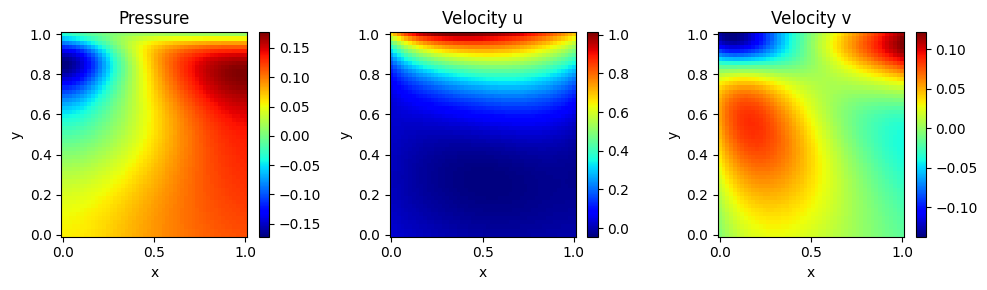

In [30]:
total_losses = []
iteration = []
boundary_loss = []
epochs = 10000

pinn.train()
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()

    #Initial value loss
    u, v, p = pinn(x_interior, y_interior, t_initial)
    u_initial_loss = torch.mean( u**2 )
    v_initial_loss = torch.mean( v**2 )
    p_initial_loss = torch.mean( p**2 )
    initial_loss = u_initial_loss + v_initial_loss + p_initial_loss

    #Boundary loss, 1- top "y=1"
    u, v , p = pinn(x_physics, y_up, t_physics)
    u_top_loss = torch.mean( (u-1)**2 )
    v_top_loss = torch.mean( v**2 )
    p_top_loss = torch.mean( p**2 )
    top_loss = u_top_loss + v_top_loss + p_top_loss

    #Boundary loss, 2 - down "y=0"
    u, v , p = pinn(x_physics, y_down, t_physics)
    u_down_loss = torch.mean( u**2 )
    v_down_loss = torch.mean( v**2 )
    p_y = torch.autograd.grad(p, y_down, torch.ones_like(p), create_graph=True)[0]
    p_down_loss = torch.mean( p_y**2 )
    down_loss = u_down_loss + v_down_loss + p_down_loss

    # Boundary loss, 3 - left "x=0"
    u, v , p = pinn(x_left, y_physics, t_physics)
    u_left_loss = torch.mean( u**2 )
    v_left_loss = torch.mean( v**2 )
    p_x = torch.autograd.grad(p, x_left, torch.ones_like(p), create_graph=True)[0]
    p_left_loss = torch.mean( p_x**2 )
    left_loss = u_left_loss + v_left_loss + p_left_loss

    # Boundary loss, 4 - right "x=1"
    u, v , p = pinn(x_right, y_physics, t_physics)
    u_right_loss = torch.mean( u**2 )
    v_right_loss = torch.mean( v**2 )
    p_x = torch.autograd.grad(p, x_right, torch.ones_like(p), create_graph=True)[0]
    p_right_loss = torch.mean( p_x**2 )
    right_loss = u_right_loss + v_right_loss + p_right_loss

    #losses for each variable u, v, p
    u_loss = u_initial_loss + u_top_loss + u_left_loss + u_down_loss + u_right_loss
    v_loss = v_initial_loss + v_top_loss + v_left_loss + v_down_loss + v_right_loss
    p_loss = p_initial_loss + p_top_loss + p_left_loss + p_down_loss + p_right_loss

    #labled data
    u, v, p = pinn(x_train, y_train, t_train)
    labled_data_loss = (
        mse_cost_function(u, u_train) +
        mse_cost_function(v, v_train) )

    # pde loss
    pde_losses, losses_added = pde_loss(x = x_physics, y = y_physics, t = t_physics, net = pinn  )
    # pde_loss0 = mse_cost_function(losses_added, torch.zeros((examples_num,1)))
    # loss = losses_added +  u_loss +  1e-2 * v_loss + 1e-2 * p_loss + 1e-3 * labled_data_loss
    loss = losses_added +  top_loss + down_loss + right_loss + left_loss + initial_loss

    # back propagation
    loss.backward()
    optimizer.step()
    total_losses.append(loss.detach())
    # if epoch % 1000 == 0:
    #     total_losses.append(loss.detach())
    #     print(total_losses[-1])

    if epoch % 1000 == 0:
      pinn.eval()
      # print(f"u: {u_loss.item()}, v: {v_loss.item()}, p:{p_loss.item()}, pde:{losses_added.item()}")
      print(f"top: {top_loss.item()}, right: {right_loss.item()}, down:{down_loss.item()}, left: {left_loss.item()}")
      print(f"initial loss: {initial_loss.item()} pde:{losses_added.item()}")
      torch.save(pinn.state_dict(), "pinn.pth")
      with torch.inference_mode():
        plot_final_t_step(pinn, vector_lines=False)
      pinn.train()

#Comapring FD with PINN
In this part, we will compare the results obtained using the finite difference with the results obtained through the physics-informed neural network in terms of velocity. The values of the pressure differes greatly between the two, but what is more important is the value of the pressure gradient.

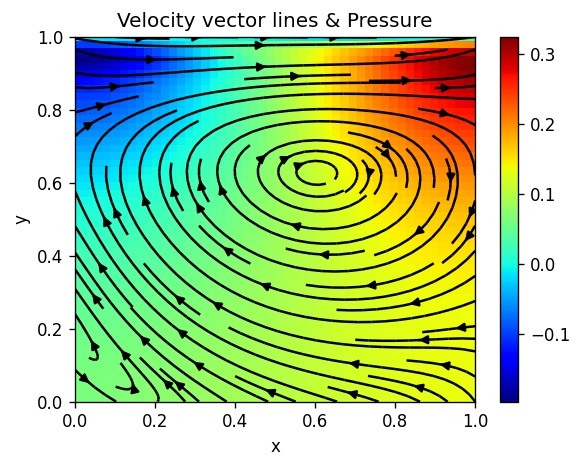

In [37]:
#comparison
pinn.eval()
with torch.inference_mode():
  x_test = torch.linspace(x_0, x_f, 50).to(device)
  y_test = torch.linspace(y_0, y_f , 50).to(device)
  test_data = torch.cartesian_prod(x_test, y_test, torch.tensor([t_f]).to(device))
  x_input_test, y_input_test, t_input_test = torch.split(test_data, 1, 1)

  #create a mesh
  x_test, y_test = x_test.cpu(), y_test.cpu()
  x_grid, y_grid = torch.meshgrid(x_test, y_test, indexing="xy")
  u_pinn, v_pinn, p_pinn = pinn(x_input_test, y_input_test, t_input_test)
  u_pinn = u_pinn.squeeze().reshape(x_grid.shape).T.cpu().numpy()
  v_pinn = v_pinn.squeeze().reshape(x_grid.shape).T.cpu().numpy()
  p_pinn = p_pinn.squeeze().reshape(x_grid.shape).T.cpu().numpy()
  u_diff = abs(u_pinn - u_fd)
  v_diff = abs(v_pinn - v_fd)
  p_diff = abs(p_pinn - p_fd)
  plot_stream_lines(x_test, y_test, u_pinn, v_pinn, p_pinn)

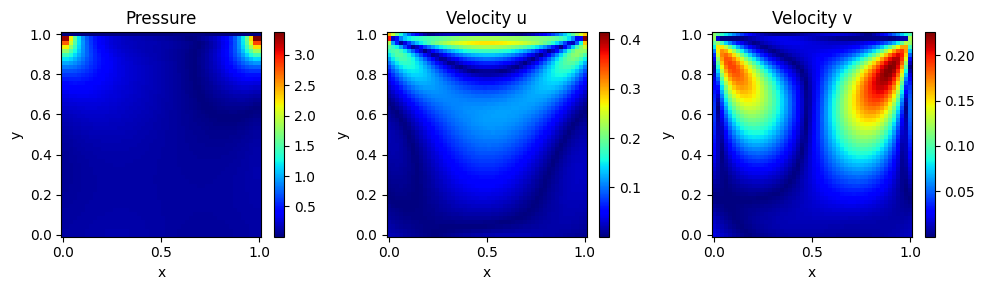

Mean squared error for velocity u: 0.006970223412484199
Mean squared error for velocity v: 0.005723519573328546


In [35]:
plot_pressure_velocity(x_test, y_test, u_diff, v_diff, p_diff)
print(f"Mean squared error for velocity u: {np.mean(u_diff**2)}")
print(f"Mean squared error for velocity v: {np.mean(v_diff**2)}")